# Prototype Static Model of Malfunction Prediction System

In [24]:
# Import Required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
def load_data(path):
    data = pd.read_csv(path)
    return data
data = load_data("D:\\EY Hackathon\\Data Layer\\models\\v1\\dataset\\synthetic_telemetry_data.csv")

In [35]:
# Preprocess Data
def preprocess_data(data):
    # delete columns vehicle_id, engine_failure_imminent, brake_issue_imminent, battery_issue_imminent, failure_date, failure_type
    data = data.drop(columns=['vehicle_id'])
    # Handle Null Values
    data = data.dropna()
    data = data.drop(columns=['failure_type'])
    # Apply one-hot encoding on column 'brand'
    data = pd.get_dummies(data, columns=['brand'])
    # Split Timestamp into three cols - year, month, date
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = data['timestamp'].dt.day
    data['failure_date'] = pd.to_datetime(data['failure_date'])
    data['failure_year'] = data['failure_date'].dt.year
    data['failure_month'] = data['failure_date'].dt.month
    data['failure_day'] = data['failure_date'].dt.day
    data = data.drop(columns=['failure_date'])
    data = data.drop(columns=['timestamp'])
    # split data into train and test
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    return train_data, test_data
train_data, test_data = preprocess_data(data)

## Preliminary Data Visulaization

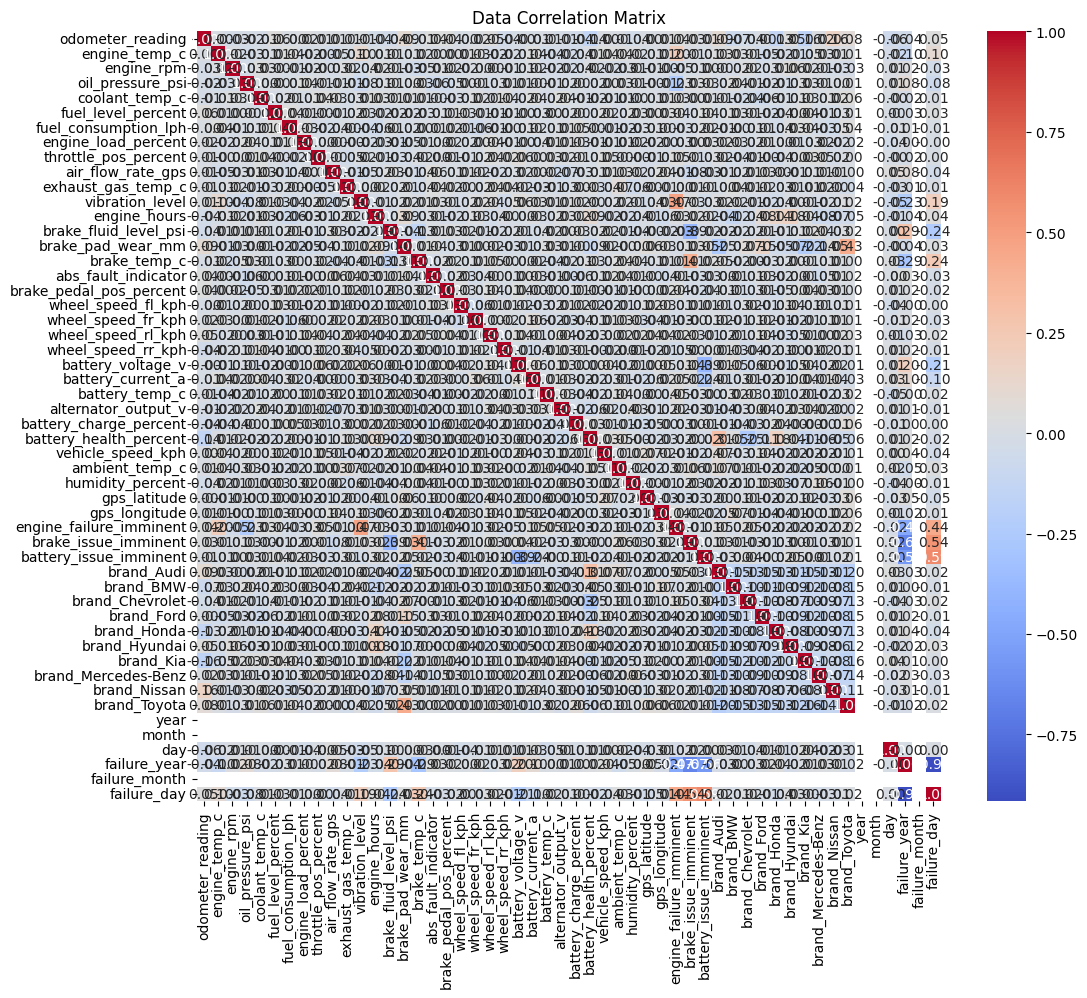

In [ ]:
# Plot the matrix of data distribution
def plot_data_distribution(data):
    plt.figure(figsize=(12,10))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Data Correlation Matrix')
    plt.show()
plot_data_distribution(train_data)

## Model Development

In [31]:
# Model Class
class ModelTrainer:
    def setBestModelIndex(self, bestModelIndex: dict):
        self.bestModelIndex = bestModelIndex
    def train_model(self, train_data, target: dict):
        all_extra_cols = target['classification_type']+target['regression_type']
        features = train_data.drop(columns=all_extra_cols)
        classificationLabels = train_data[target['classification_type']]

        # Iterate through each target and train a separate model
        self.models = {}
        for t in target['classification_type']:
            # Use RandomForestClassifier, XGBoost, LightGBM for training
            from sklearn.ensemble import RandomForestClassifier
            rfModel = RandomForestClassifier(n_estimators=100, random_state=42)
            xgbModel = xgb.XGBClassifier()
            lightGBMModel = lgb.LGBMClassifier()
            # Train the models
            rfModel.fit(features, classificationLabels[t])
            xgbModel.fit(features, classificationLabels[t])
            lightGBMModel.fit(features, classificationLabels[t])
            self.models[t] = [rfModel, xgbModel, lightGBMModel]
        return self.models
    def evaluate_model(self, test_data, target: list[str]):
        features = test_data.drop(columns=target+['failure_year', 'failure_month', 'failure_day'])
        labels = test_data[target]

        evaluation_results = {}
        for t in target:
            rfModel, xgbModel, lightGBMModel = self.models[t]
            predictions1 = rfModel.predict(features)
            predictions2 = xgbModel.predict(features)
            predictions3 = lightGBMModel.predict(features)

            evaluation_results[t] = {
                'RandomForest': {
                    'accuracy': accuracy_score(labels[t], predictions1),
                    'precision': precision_score(labels[t], predictions1),
                    'recall': recall_score(labels[t], predictions1),
                    'f1_score': f1_score(labels[t], predictions1)
                },
                'XGBoost': {
                    'accuracy': accuracy_score(labels[t], predictions2),
                    'precision': precision_score(labels[t], predictions2),
                    'recall': recall_score(labels[t], predictions2),
                    'f1_score': f1_score(labels[t], predictions2)
                },
                'LightGBM': {
                    'accuracy': accuracy_score(labels[t], predictions3),
                    'precision': precision_score(labels[t], predictions3),
                    'recall': recall_score(labels[t], predictions3),
                    'f1_score': f1_score(labels[t], predictions3)
                }
            }

            # Plot Model Evaluation Results
            for model_name, metrics in evaluation_results[t].items():
                print(f"Model: {model_name}")
                for metric_name, value in metrics.items():
                    print(f"{metric_name}: {value:.4f}")
                plt.figure(figsize=(6,4))
                cm = confusion_matrix(labels[t],
                                      rfModel.predict(features) if model_name == 'RandomForest' else
                                      xgbModel.predict(features) if model_name == 'XGBoost' else
                                      lightGBMModel.predict(features))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix for {model_name} on {t}')
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.show()
                sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
                plt.title(f'Metrics for {model_name} on {t}')
                plt.ylabel('Score')
                plt.ylim(0, 1)
                plt.show()
        return evaluation_results
    def infer(self, new_data, target: str):
        features = new_data.drop(columns=[target])
        bestModel = self.models[target][self.bestModelIndex[target]]
        prediction = bestModel.predict(features)
        return prediction

[LightGBM] [Info] Number of positive: 7, number of negative: 1569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8185
[LightGBM] [Info] Number of data points in the train set: 1576, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004442 -> initscore=-5.412284
[LightGBM] [Info] Start training from score -5.412284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\amand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\amand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\amand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[

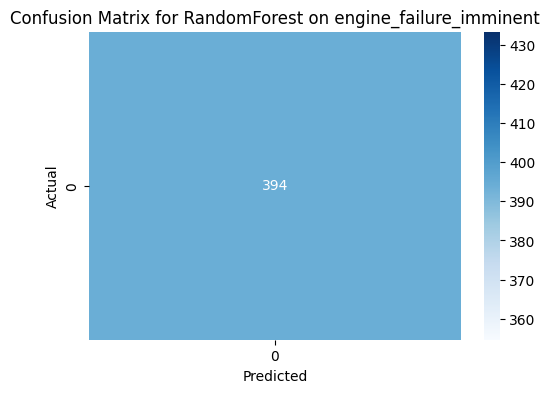

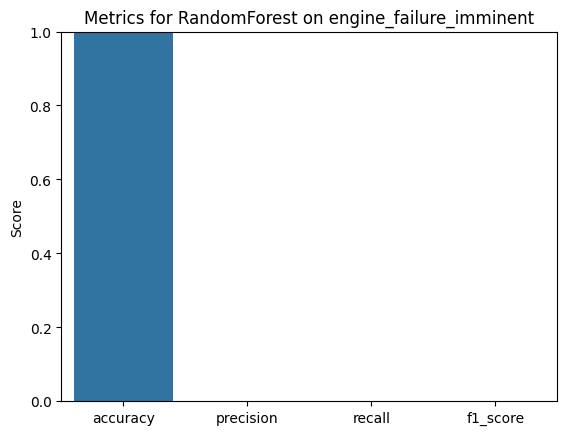

Model: XGBoost
accuracy: 1.0000
precision: 0.0000
recall: 0.0000
f1_score: 0.0000


C:\Users\amand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


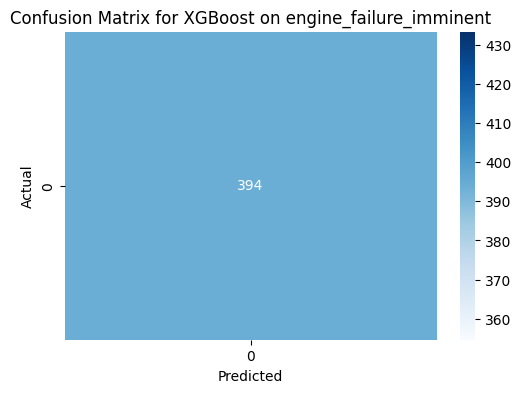

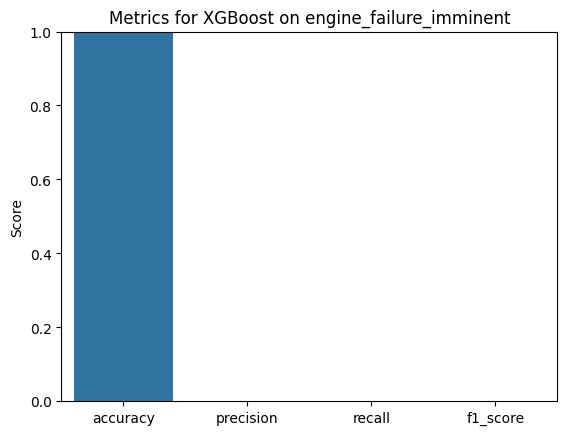

Model: LightGBM
accuracy: 1.0000
precision: 0.0000
recall: 0.0000
f1_score: 0.0000


C:\Users\amand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


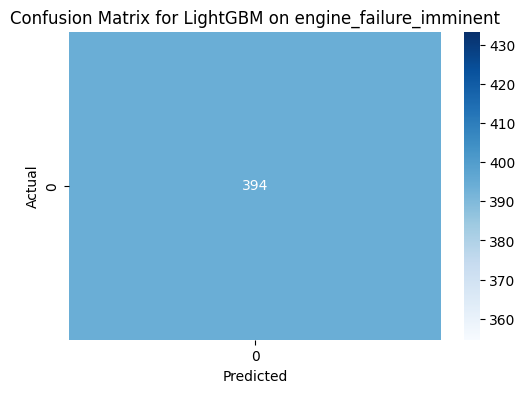

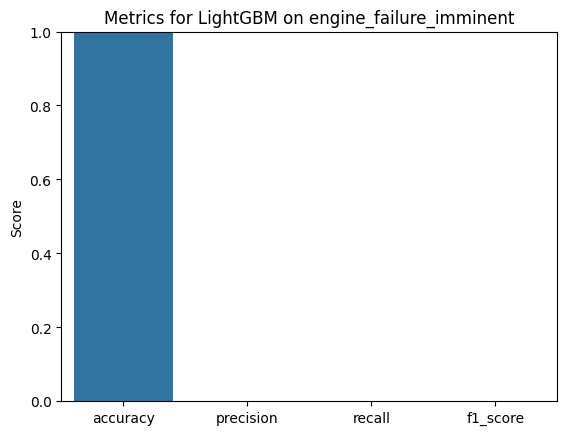

Model: RandomForest
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1_score: 1.0000


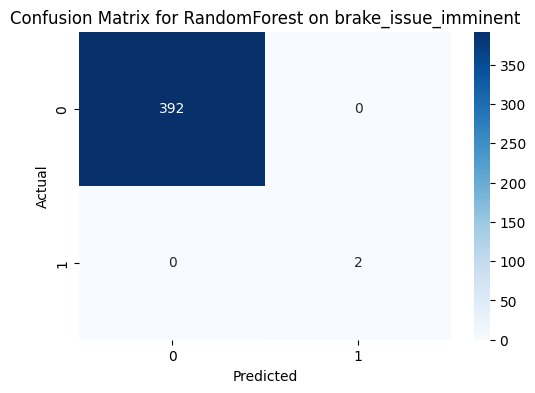

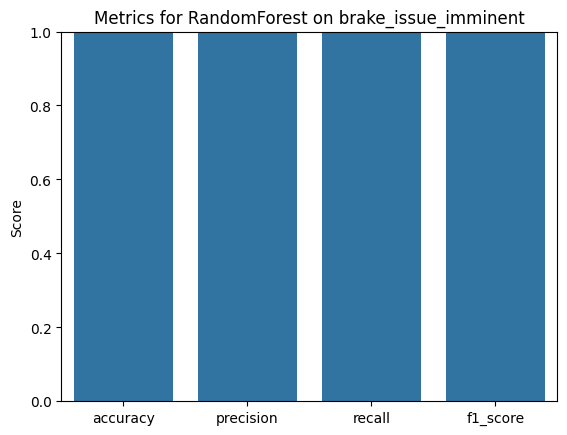

Model: XGBoost
accuracy: 0.9975
precision: 0.6667
recall: 1.0000
f1_score: 0.8000


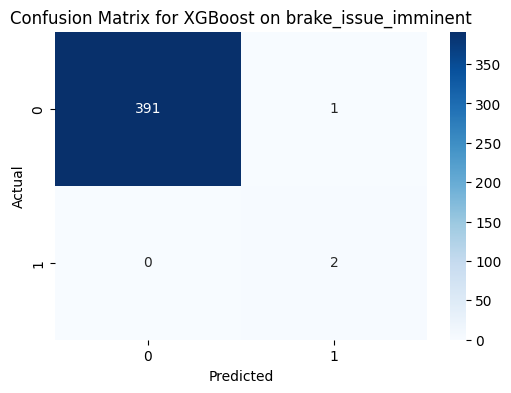

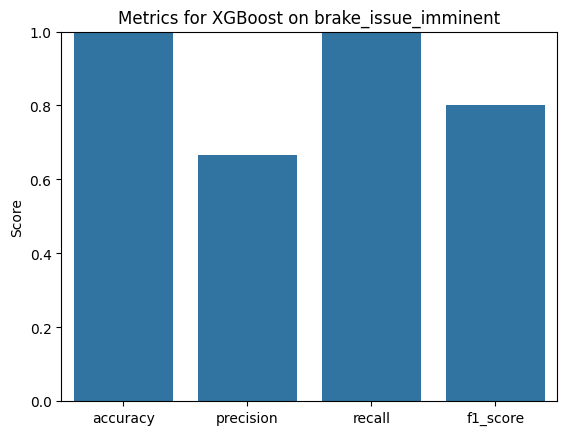

Model: LightGBM
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1_score: 1.0000


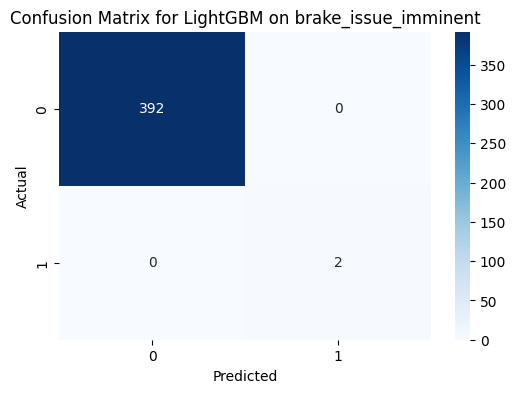

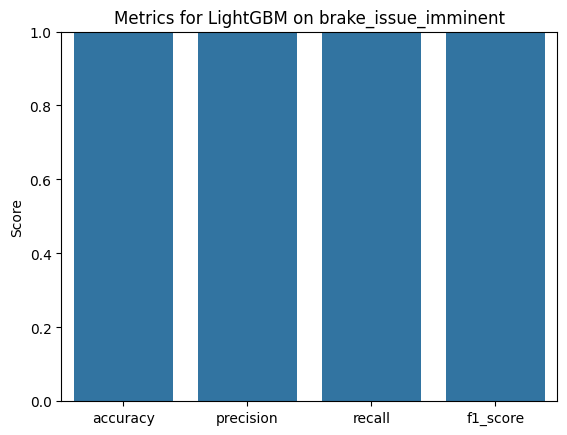

Model: RandomForest
accuracy: 0.9949
precision: 0.0000
recall: 0.0000
f1_score: 0.0000


C:\Users\amand\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


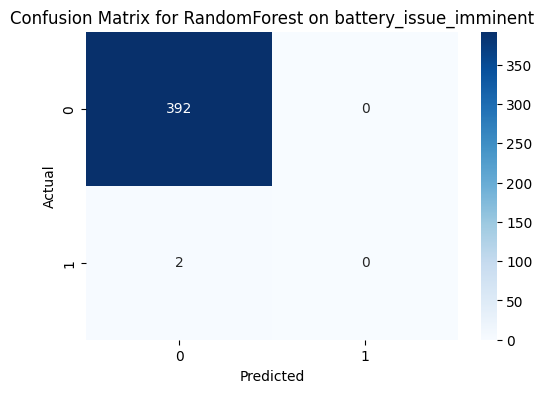

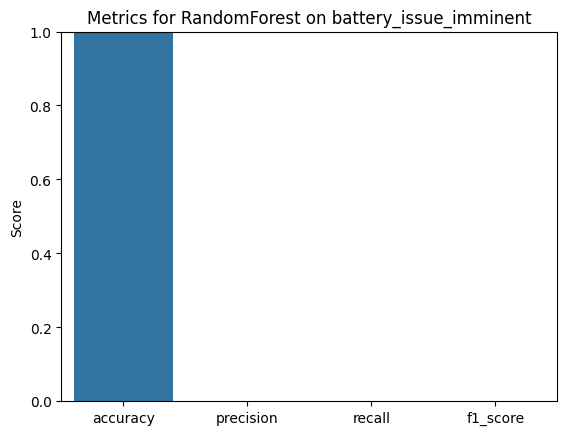

Model: XGBoost
accuracy: 0.9975
precision: 1.0000
recall: 0.5000
f1_score: 0.6667


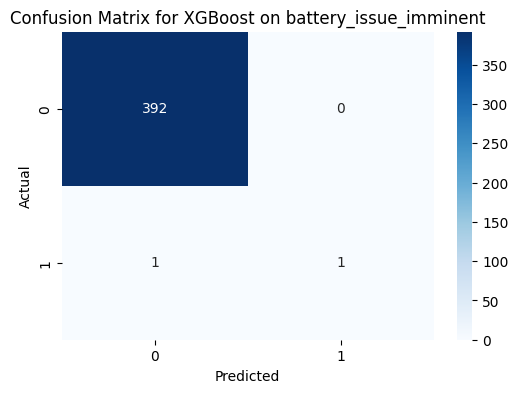

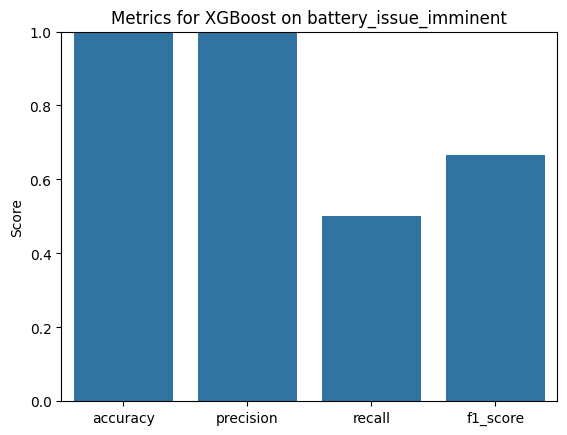

Model: LightGBM
accuracy: 0.9975
precision: 1.0000
recall: 0.5000
f1_score: 0.6667


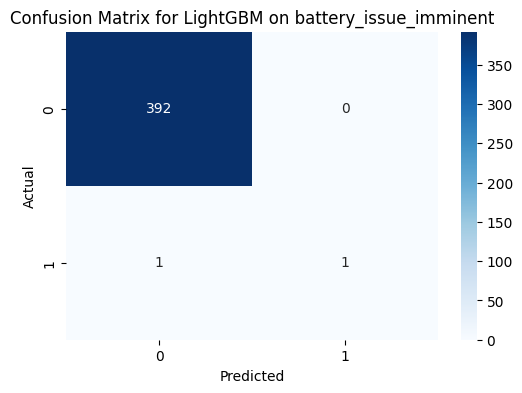

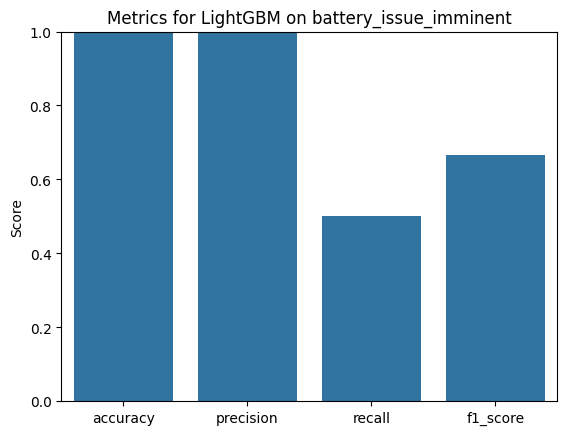

In [32]:
modelInstance = ModelTrainer()
target_columns = {'classification_type': ['engine_failure_imminent', 'brake_issue_imminent', 'battery_issue_imminent'], 'regression_type': ['failure_year', 'failure_month', 'failure_day']}
modelInstance.train_model(train_data, target_columns)
evaluation_results = modelInstance.evaluate_model(test_data, target_columns['classification_type'])